In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
from datetime import datetime as dt, timedelta

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
conn = engine.connect()

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(bind = engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
conn = engine.connect()
recent_date = pd.read_sql('SELECT date FROM measurement ORDER BY date DESC', conn)
most_recent = recent_date.loc[0]
print(most_recent[0])



2017-08-23


<class 'list'>


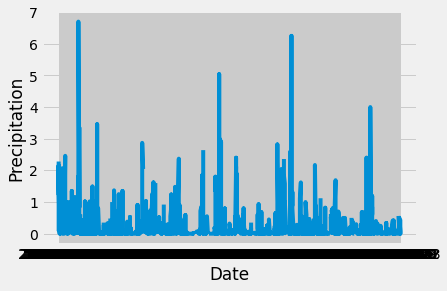

In [18]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

date_converted = dt.strptime('2017-08-23',"%Y-%m-%d")

# Calculate the date one year from the last date in data set.
year_previous = date_converted - timedelta(days = 365)
year_previous

# Perform a query to retrieve the data and precipitation scores
scores = session.query(measurement.date, measurement.prcp) .\
    filter(measurement.date <= date_converted, measurement.date > year_previous) .\
    order_by(measurement.date).all()   



# Save the query results as a Pandas DataFrame and set the index to the date column
precipitation_df = pd.DataFrame(scores, columns=['Date', 'Precipitation'])
precipitation_df.set_index('Date', inplace=True)

# Sort the dataframe by date
precipitation_df_sorted = precipitation_df.sort_values(by = 'Date')

# Use Pandas Plotting with Matplotlib to plot the data

plt.plot(precipitation_df_sorted)
plt.xlabel('Date')
plt.ylabel('Precipitation')
plt.show()



In [11]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precipitation_mean = precipitation_df['Precipitation'].mean()
precipitation_median = precipitation_df['Precipitation'].median()
precipitation_variance = precipitation_df['Precipitation'].var()
precipitation_stdev = precipitation_df['Precipitation'].std()
precipitation_sem = precipitation_df['Precipitation'].sem()
precipitation_summary = pd.DataFrame({
    'Mean Precipitation' : precipitation_mean,
    'Median Precipitation' : precipitation_median,
    'Precipitation Variance' : precipitation_variance,
    'Precipitation Std. Dev.' : precipitation_stdev,
    'Precipitation Std. Err.' : precipitation_sem,
}, index = [0])
precipitation_summary

,Mean Precipitation,Median Precipitation,Precipitation Variance,Precipitation Std. Dev.,Precipitation Std. Err.
0,0.176462,0.02,0.211865,0.460288,0.010254


# Exploratory Station Analysis

In [12]:
# Design a query to calculate the total number stations in the dataset
rows = session.query(station).count()
print(f'There are {rows} stations.')

There are 9 stations.


In [13]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
stations = session.query(measurement.station,func.count(measurement.date)). \
    group_by(measurement.station).order_by(func.count(measurement.date).desc()).all()


stations



[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [14]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
#most active station is USC00519281
lowest = session.query(func.min(measurement.tobs)) .\
    filter(measurement.station == 'USC00519281').all()
highest = session.query(func.max(measurement.tobs)) .\
    filter(measurement.station == 'USC00519281').all()
avg = session.query(func.avg(measurement.tobs)) .\
    filter(measurement.station == 'USC00519281').all()

print(f'Lowest recorded temperature: {lowest}\nHighest recorded temperature: {highest}\nAverage temperature: {avg}')

Lowest recorded temperature: [(54.0,)]
Highest recorded temperature: [(85.0,)]
Average temperature: [(71.66378066378067,)]


Text(0, 0.5, 'Frequency')

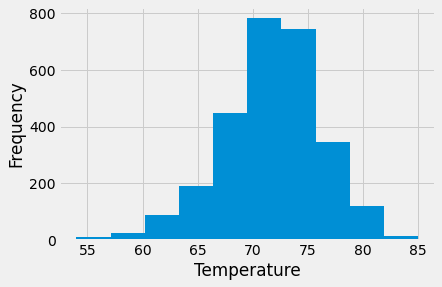

In [15]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
last_year_temps = session.query(measurement.date, measurement.tobs) .\
    filter(measurement.station == 'USC00519281').all()


last_year_temps

temp_df = pd.DataFrame(last_year_temps, columns=['Date', 'Temperature'])
temp_df.set_index('Date', inplace=True)


temp_df

plt.hist(temp_df)
plt.xlabel('Temperature')
plt.ylabel('Frequency')

# Close session

In [16]:
# Close Session
session.close()